This is a demonstration of how one defines a Nerual Network using torch's Modules. This notebook defines the simplest neural network with only Input layers, Fully Connected Layers and Output Layers.\
For ease of reference, this architecture of the neural network is referred to as a 'Fully Connected Network' throughout the whole topic.

In [1]:
import torch

from torch import nn
from torch.utils.data import random_split, DataLoader, Dataset

import matplotlib.pyplot as plt

import math

# Sample Data

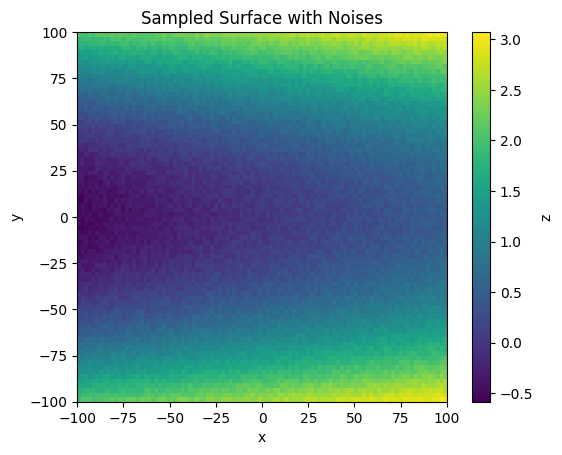

In [2]:
x = torch.linspace(-100, 100, 100)
y = torch.linspace(-100, 100, 80)

xx, yy = torch.meshgrid(x, y, indexing='xy')

z = (5 * xx + (0.5 * yy) ** 2 - 100) / 1000 + torch.rand(xx.shape) * .2


plt.imshow(z, extent=[x[0], x[-1], y[0], y[-1]])
plt.title('Sampled Surface with Noises')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('z')

In [3]:
features = torch.cat([xx.reshape((-1,1)), yy.reshape((-1,1))], 1)
labels = z.reshape((-1, 1))

# First Model Definition

In [4]:
class ParabolaDataset(Dataset):
    def __init__(self, features, targets):
        if features.shape[0] != targets.shape[0]:
            raise ValueError('Features and Labels have different lengths!')
        super().__init__()
        self.features = features
        self.targets = targets
    
    def __len__(self) -> int:
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]

In [5]:
class SimpleNetwork(nn.Module):
    """
    A simple Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, values):
        return self.layers(values)

In [7]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: nn.Module,
    track_loss: bool = False
):
    """
    Performs backpropogation on `model` using `optimizer`.

    :param nn.Module model: The model on which to perform backpropogation.
    :param nn.utils.data.DataLoader train_loader: A DataLoader dispatching batches
        for each backpropogations.
    :param nn.Module loss_fn: The loss function to based on which to compute gradients.
    :param nn.Module optimizer: The optimization algorithm for gradient descent.
    :param bool track_loss: Whether or not to print out statistics on each backpropogation.
        This is `False` by default.
    """
    model.train()
    if track_loss:
        num_digits = int(math.log10(len(train_loader))) + 1
    for batch, (X, y) in enumerate(train_loader, start=1):
        pred_value = model(X)
        loss = loss_fn(pred_value, y)

        # Compute the gradient with loss.backward()
        # Then backpropogate with optimizer.step()
        # However, to avoid accumulation of previous backward passes
        # we need to call optimizer.zero_grad() to zero out the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if track_loss:
            print(f"Batch {batch:>{num_digits}}/{len(train_loader)} || Loss: {loss}")
def test_model(
    model: nn.Module,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    compute_accuracy: bool
) -> tuple[float, float]:
    """
    Evaluate `model` based on `loss_fn` and return the average score(s).

    :param nn.Module model: The model on which to perform evaluation.
    :param nn.utils.data.DataLoader test_loader: A DataLoader containing test data.
    :param nn.Module loss_fn: The loss function to based on which to compute metrics.
    :param bool compute_accuracy: Whether or not to compute accuracy. This is only
        meaningful in the case the `model` is a classifier.
    :return: The average loss (per batch) and average accuracy (per sample). If
        `compute_accuracy=False` then average accuracy returned is 0.
    :rtype: tuple[float, float]
    """
    model.eval()
    total_loss, total_accuracy = 0, 0
    for X, y in test_loader:
        pred = model(X)
        total_loss += loss_fn(pred, y)
        if compute_accuracy:
            labels = (pred.argmax(dim=1) == y)
            total_accuracy += labels.type(torch.int).sum().item()
    return total_loss / len(test_loader), total_accuracy / len(test_loader.dataset)

# Training and Evaluation

In [9]:

def train_epochs(
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module,
    epochs: int
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ', flush=True)
        train_model(model, train_loader, loss_fn, optimizer)
        loss, acc = test_model(model, test_loader, loss_fn, False)
        if not epoch % update_rate:
            print(f"Average Loss: {loss:.6f}", flush=True)

In [10]:
batch_size = 64
learning_rate = 0.0001

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

model = SimpleNetwork(2, 1, 10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
train_epochs(model, train_loader, test_loader, loss_fn, optimizer,
             20)

Epoch  1/20 || Average Loss: 1.242242
Epoch  2/20 || Average Loss: 1.174549
Epoch  3/20 || Average Loss: 1.115673
Epoch  4/20 || Average Loss: 1.064412
Epoch  5/20 || Average Loss: 1.019734
Epoch  6/20 || Average Loss: 0.980708
Epoch  7/20 || Average Loss: 0.946597
Epoch  8/20 || Average Loss: 0.916726
Epoch  9/20 || Average Loss: 0.890517
Epoch 10/20 || Average Loss: 0.867491
Epoch 11/20 || Average Loss: 0.847209
Epoch 12/20 || Average Loss: 0.829355
Epoch 13/20 || Average Loss: 0.813561
Epoch 14/20 || Average Loss: 0.799557
Epoch 15/20 || Average Loss: 0.787134
Epoch 16/20 || Average Loss: 0.776083
Epoch 17/20 || Average Loss: 0.766216
Epoch 18/20 || Average Loss: 0.757388
Epoch 19/20 || Average Loss: 0.749465
Epoch 20/20 || Average Loss: 0.742333


# Weights Interpretation
The purpose of this section is to demonstrate how the activation function introduce non-linearity into the model.
This also show how good the model can fit into seen data.\
However, this ONLY shows a part of the model's performance. One must also judge how good the model fits into unseen
data in order to accurately determine the model's performance.

In [12]:
state_dict = model.state_dict()
state_dict

OrderedDict([('layers.1.weight',
              tensor([[-0.3918,  0.3745],
                      [-0.2697, -0.1745],
                      [-0.0365,  0.4710],
                      [ 0.3005,  0.0057],
                      [ 0.5635, -0.1137],
                      [ 0.0986,  0.5990],
                      [ 0.5053,  0.6056],
                      [-0.2473,  0.0050],
                      [-0.1038,  0.3079],
                      [-0.5574, -0.5103]])),
             ('layers.1.bias',
              tensor([ 0.4856, -0.6126, -0.4555,  0.3688, -0.1929,  0.5290,  0.1908,  0.3180,
                       0.6832,  0.6093])),
             ('layers.3.weight',
              tensor([[ 0.2766,  0.0017, -0.0581, -0.1800,  0.2597,  0.0702,  0.1353, -0.1600,
                       -0.0250,  0.0639]])),
             ('layers.3.bias', tensor([0.4530]))])

In [13]:
linear_comb = features @ state_dict['layers.1.weight'].T
first_layer_res = torch.relu(linear_comb + state_dict['layers.1.bias'])
linear_comb_2 = first_layer_res @ state_dict['layers.3.weight'].T
output_layer = linear_comb_2 + state_dict['layers.3.bias']
output_layer

# or easily call model(features)
# remember to set model to eval before interference

tensor([[ 4.0710],
        [ 3.8592],
        [ 3.6474],
        ...,
        [22.8777],
        [23.1311],
        [23.4792]])

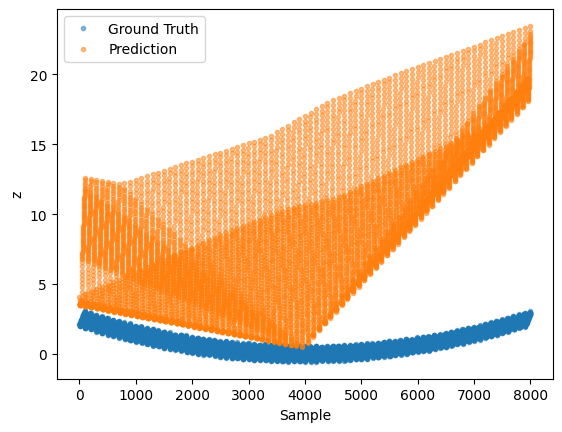

In [14]:
plt.plot(labels, '.', label='Ground Truth', alpha=.5)
plt.plot(output_layer, '.', label='Prediction', alpha=.5)
plt.xlabel('Sample')
plt.ylabel('z')
plt.legend();

In [15]:
def draw_predicted_surface(
    heights, ax,
    title='',
    extent=None
):
    img = ax.imshow(heights, extent=extent)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = ax.get_figure().colorbar(img)
    cbar.set_label('z');
    return ax, img

(<Axes: title={'center': 'Predicted Surface from Model'}, xlabel='x', ylabel='y'>,
 <matplotlib.image.AxesImage at 0x23512663890>)

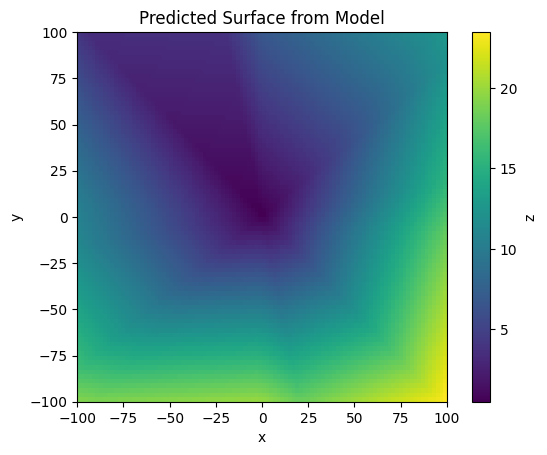

In [16]:
draw_predicted_surface(
    output_layer.reshape(xx.shape), plt.gca(),
    'Predicted Surface from Model',
    [x[0], x[-1], y[0], y[-1]]
)

# Second Model Definition

In [17]:
class MultiLayerPerceptron(nn.Module):
    """
    A Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self,
        input_output_dim: tuple[int, int],
        hidden_dim: tuple[int]
    ):
        super().__init__()
        self.layers = nn.Sequential(nn.Flatten())

        relu = nn.ReLU()
        hidden_dim = input_output_dim[0:1] + hidden_dim
        for i in range(1, len(hidden_dim)):
            self.layers.add_module(f'{2 * i - 1}', nn.Linear(hidden_dim[i-1], hidden_dim[i]))
            self.layers.add_module(f'{2 * i}', relu)
        self.layers.add_module(f'out', nn.Linear(hidden_dim[-1], input_output_dim[1]))
        
    def forward(self, values):
        return self.layers(values)

Training and Evaluation

In [18]:
learning_rate = 0.001

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

mlp_model_1 = MultiLayerPerceptron((2, 1), (10, 10))
mlp_model_2 = MultiLayerPerceptron((2, 1), (50, 50))
mlp_model_3 = MultiLayerPerceptron((2, 1), (50, 50, 50, 50))

loss_fns = [nn.MSELoss(), nn.MSELoss(), nn.MSELoss()]
optimizers = [
    torch.optim.SGD(mlp_model_1.parameters(), lr=learning_rate),
    torch.optim.SGD(mlp_model_2.parameters(), lr=learning_rate),
    torch.optim.SGD(mlp_model_3.parameters(), lr=learning_rate),
]

In [19]:
epochs = 40

print('Training First Model:')
train_epochs(mlp_model_1, train_loader, test_loader, loss_fns[0], optimizers[0],
             epochs)

print('\nTraining Second Model:')
train_epochs(mlp_model_2, train_loader, test_loader, loss_fns[1], optimizers[1],
             epochs)

print('\nTraining Third Model:')
train_epochs(mlp_model_3, train_loader, test_loader, loss_fns[2], optimizers[2],
             epochs)

Training First Model:
Epoch  1/40 || Average Loss: 0.169051
Epoch 11/40 || Average Loss: 0.045616
Epoch 21/40 || Average Loss: 0.039166
Epoch 31/40 || Average Loss: 0.034123

Training Second Model:
Epoch  1/40 || Average Loss: 0.813629
Epoch 11/40 || Average Loss: 0.534830
Epoch 21/40 || Average Loss: 0.516098
Epoch 31/40 || Average Loss: 0.511463

Training Third Model:
Epoch  1/40 || Average Loss: 0.053988
Epoch 11/40 || Average Loss: 0.034949
Epoch 21/40 || Average Loss: 0.031476
Epoch 31/40 || Average Loss: 0.029720


Interpreting the weights

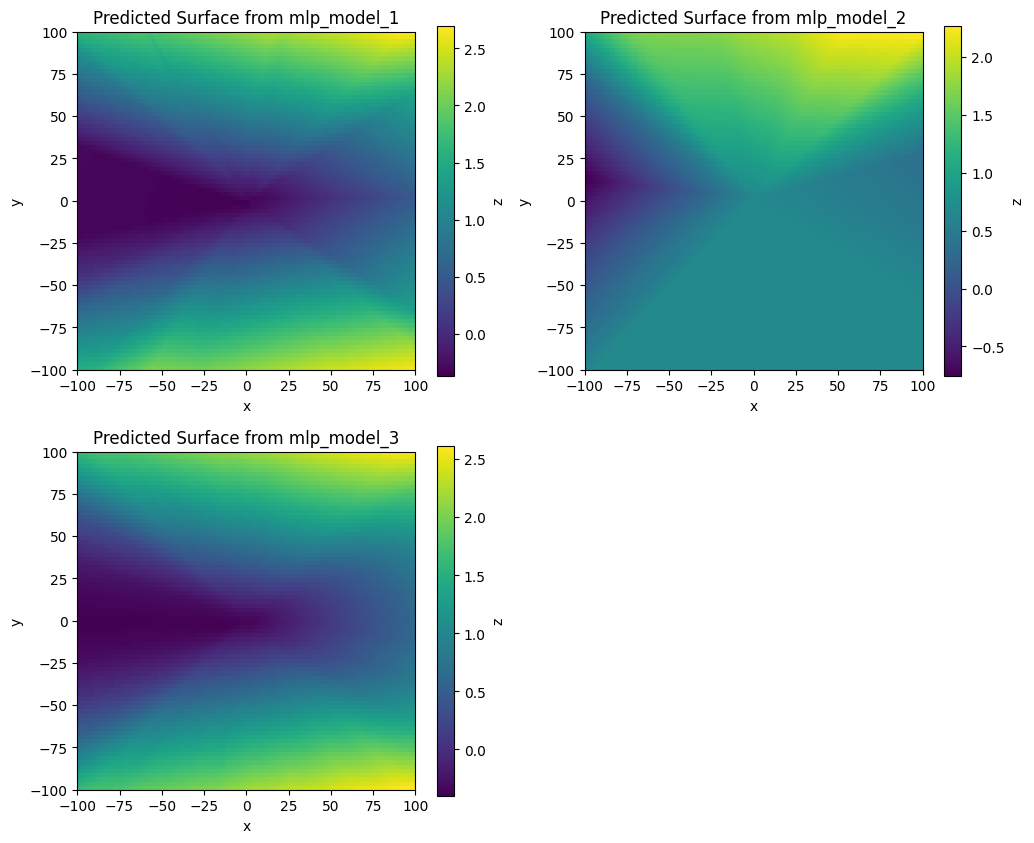

In [20]:
mlp_model_1.eval()
mlp_model_2.eval()
mlp_model_3.eval()
predictions = [
    mlp_model_1(features).detach(),
    mlp_model_2(features).detach(),
    mlp_model_3(features).detach(),
]


fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
axes = fig.subplot_mosaic(
    [[0, 1], [2, '.']]
)

extent = [x[0], x[-1], y[0], y[-1]]
temp_title_fn = lambda num: f'Predicted Surface from mlp_model_{num}'
draw_predicted_surface(
    predictions[0].reshape(xx.shape), axes[0],
    temp_title_fn(1),
    extent=extent
)
draw_predicted_surface(
    predictions[1].reshape(xx.shape), axes[1],
    temp_title_fn(2),
    extent=extent
)
draw_predicted_surface(
    predictions[2].reshape(xx.shape), axes[2],
    temp_title_fn(3),
    extent=extent
);